# 투자전략 1: 모멘텀 투자 - KOSPI200

![모멘텀 투자](img/momentum.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import logging
from IPython.display import Image

In [15]:
pd.options.display.max_columns = 100 # was 20
pd.options.display.max_rows = 30 # was 60
logger = logging.getLogger('zero_remove_logger')

크롤링 과정 생략. 

In [7]:
df = pd.read_pickle('KOSPI200_2013-2018.p')

In [8]:
t = pd.Timedelta('180 days') # 180일 간격으로 window가 움직인다. 

In [11]:
class MovingWindow:
    def __init__(self):
        self.top100firms = []
        self.top100 = pd.DataFrame()
        self.holding = pd.DataFrame()
        self.window = pd.Timedelta('365 days')
        self.balance = 0
        self.total_investment = 1
        self.current_date = pd.Timestamp('2016-12-30 00:00:00') # 너무 많은 주식들이 2014.12.31엔 0원이다.2015도... # 중요! S&P500 돌릴땐 12.30으로 해야함. 2016.12.31이 공휴일이었나봐. 
    
    def get_top100(self):
        basket = pd.DataFrame()
        basket['firms'] = df.columns[1:]
        basket['ipo_index'] = df.drop(['date'], axis=1).ne(0).idxmax().values #마지막에 values 붙여줘야 series를 df에 column으로 부착 가능. 
        basket['ipo_price'] = 0
        
        for idx, row in basket.iterrows(): # 이 부분이 iterrows 때문에 병목이 생기는 것으로 보임. 
            basket['ipo_price'][idx] = df.drop(['date'], axis=1)[row["firms"]].iloc[row['ipo_index']]
        basket['current_price'] = df.drop(['date'], axis=1).loc[df['date']==self.current_date].squeeze().values
        
        basket = basket[basket.current_price > basket.ipo_price] # +수익률만 남김.
        
        basket['price_change'] = 100*(basket.current_price - basket.ipo_price)/basket.ipo_price
        basket = basket.sort_values(by='price_change', ascending=False) # 수익률 순으로 내림차순 정렬. 
        
        basket['holding'] = 100
        
        self.top100 = basket.head(100)
        self.holding = self.top100[['firms', 'holding']]
        self.top100firms = list(self.top100.firms)
        
        self.top100['TR'] = self.top100.current_price * self.top100.holding
        self.top100['TC'] = self.top100.current_price * self.top100.holding
        
        return self.top100
        
    def after_t_return(self):
        self.current_date += t
        basket = df[['date']+list(self.top100firms)]

        self.top100['firms'] = self.top100firms
        self.top100['current_price'] = basket[basket['date'] == self.current_date].drop(['date'], axis=1).squeeze().values
        
        self.top100['year_ago_price'] = basket[basket['date'] == (self.current_date - self.window)].drop(['date'], axis=1).squeeze().values
        
        for idx, row in self.top100.iterrows(): # t만큼 이동 후 1년 전의 시점에 아직 IPO가 안됐을 경우, 최초 IPO 가격으로 대체. 
            if row.year_ago_price == 0:
                self.top100.year_ago_price[idx] = row.ipo_price
                
        self.top100['price_change'] = 100*(self.top100.current_price - self.top100.year_ago_price)/self.top100.year_ago_price
        
        self.top100 = self.top100.sort_values(by='price_change', ascending=False) # 수익률 순으로 내림차순 정렬. 
        
        self.top100 = pd.merge(self.top100, self.holding, on=['firms'], suffixes=('_x', '')) #일단 그냥 중복 컬럼 생기게 두고, 지워버린다. 
        try:
            self.top100 = self.top100.drop(['holding_x'], axis=1)
            self.top100 = self.top100.drop(['current_price_x'], axis=1)
        except:
            pass
    
        self.top100.TR = self.top100.current_price * self.top100.holding
        
        self.top100['profit'] = self.top100.TR - self.top100.TC
        self.top100['return'] = 100*(self.top100.profit / self.top100.TC)
        
        self.balance = self.top100['profit'].sum()
        self.total_investment = self.top100['TC'].sum()
        
        return self.top100
    
    def buy_and_sell(self):                             
        buy_firms = self.top100.head(10)['firms'].values
        sell_firms = self.top100.tail(10)['firms'].values
        
        for f in buy_firms: # 중간에 매수한 비용은 해당 주식 매수 비용에 더함. 
            self.top100.loc[self.top100.firms == f, 'TC'] = self.top100.loc[self.top100.firms == f, 'TC'] + self.holding[self.holding.firms == f].holding.values[0] * 0.1 * self.top100.loc[self.top100.firms == f, 'current_price']
            self.holding.loc[self.holding.firms == f, 'holding'] = self.holding[self.holding.firms == f].holding.values[0] * 1.1 #(rebalancing에서 총 투자금액이 아닌)주식 수량을 10% 늘리는건 좀 문제가 있을 것 같지만 그냥 함. 
        
        for f in sell_firms: # 중간에 매도하여 얻은 차익은 balance에 더함. 
#             self.top100.loc[self.top100.firms == f, 'TC'] = self.top100.loc[self.top100.firms == f, 'TC'] - self.holding[self.holding.firms == f].holding.values[0] * 0.1 * self.top100.loc[self.top100.firms == f, 'current_price']
            self.balance += self.holding[self.holding.firms == f].holding.values[0] * 0.1 * self.top100.loc[self.top100.firms == f, 'current_price'] 
            self.holding.loc[self.holding.firms == f, 'holding'] = self.holding[self.holding.firms == f].holding.values[0] * 0.9 #이것도. 수량을 10% 줄임. 
        
        return self.holding
    
    def investment_return(self):
        return 100*(self.balance / self.total_investment)
        

In [18]:
def after_t_result(s):
    s.buy_and_sell()
    s.after_t_return()
    print(s.current_date)
    print("net profit: ", s.balance)
    print("total investment: ", s.total_investment)
    print("investment return (%): ", s.investment_return())

## 투자 시작. 

In [16]:
s1 = MovingWindow()

### 1기: 주식 선택

#### KOSPI200 중 2016년 12월 31일 기준으로 1년 전 가격과 비교하여 (또는 그 기간 중 IPO 가격) 가장 가격 증가율이 높은 100개를 골라 포트폴리오를 구성한다. 

In [17]:
s1.get_top100()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,firms,ipo_index,ipo_price,current_price,price_change,holding,TR,TC
187,영진약품,736,1280,8820.0,589.062500,100,882000.0,882000.0
100,대한유화,736,66600,275500.0,313.663664,100,27550000.0,27550000.0
135,한미사이언스,736,15650,61100.0,290.415335,100,6110000.0,6110000.0
58,JW홀딩스,736,2365,8880.0,275.475687,100,888000.0,888000.0
161,JW중외제약,736,14300,52700.0,268.531469,100,5270000.0,5270000.0
169,DB하이텍,736,4450,15900.0,257.303371,100,1590000.0,1590000.0
122,한올바이오파마,736,3745,13150.0,251.134846,100,1315000.0,1315000.0
159,동양,736,914,2985.0,226.586433,100,298500.0,298500.0
35,한미약품,736,97600,305500.0,213.012295,100,30550000.0,30550000.0
2,셀트리온,736,37900,107400.0,183.377309,100,10740000.0,10740000.0


In [14]:
s1.current_date

Timestamp('2016-12-30 00:00:00')


### 2기: t(여기선 6개월)가 지난 후 100개의 포트폴리오를 재평가.

#### 이 시점에서 번 돈과(각 주식 profit의 총 합 = balance) 투자한 총 금액(각 주식 Total Cost의 총 합 = total investment), 그리고 전체 투자의 수익률을 확인한다. (%) 

In [19]:
after_t_result(s1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2017-06-28 00:00:00
net profit:  156938900.0
total investment:  1483273350.0
investment return (%):  10.580578421367848


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### 3기: t(여기선 6개월)가 지난 후 100개의 포트폴리오를 재평가.

#### 이 시점에서 번 돈과(각 주식 profit의 총 합 = balance) 투자한 총 금액(각 주식 Total Cost의 총 합 = total investment), 그리고 전체 투자의 수익률을 확인한다. (%) 

In [20]:
after_t_result(s1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2017-12-25 00:00:00
net profit:  229979215.00000006
total investment:  1516702900.0
investment return (%):  15.163102477090277



### 4기: t(여기선 6개월)가 지난 후 100개의 포트폴리오를 재평가.

#### 이 시점에서 번 돈과(각 주식 profit의 총 합 = balance) 투자한 총 금액(각 주식 Total Cost의 총 합 = total investment), 그리고 전체 투자의 수익률을 확인한다. (%) 

In [21]:
after_t_result(s1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2018-06-23 00:00:00
net profit:  -106326674.99999997
total investment:  1536556845.0
investment return (%):  -6.919800939743298


그런데 이럴 수가... 삼성전자 분할 후 폭락했다고 나온다. 네이버 금융은 조정 종가(adjusted closing price)를 계산해서 넣어두지 않았던 것이다. 

In [22]:
df2 = df.set_index('date')

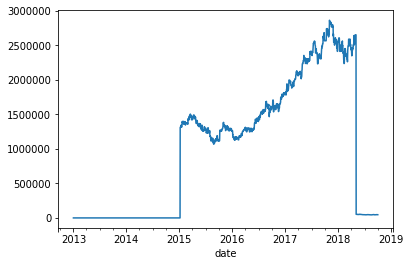

In [23]:
df2["삼성전자"].plot()